In [2]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.signal as snr
import matplotlib.pyplot as plt
import os

# Lab 3

## Exact and Appx CNOT

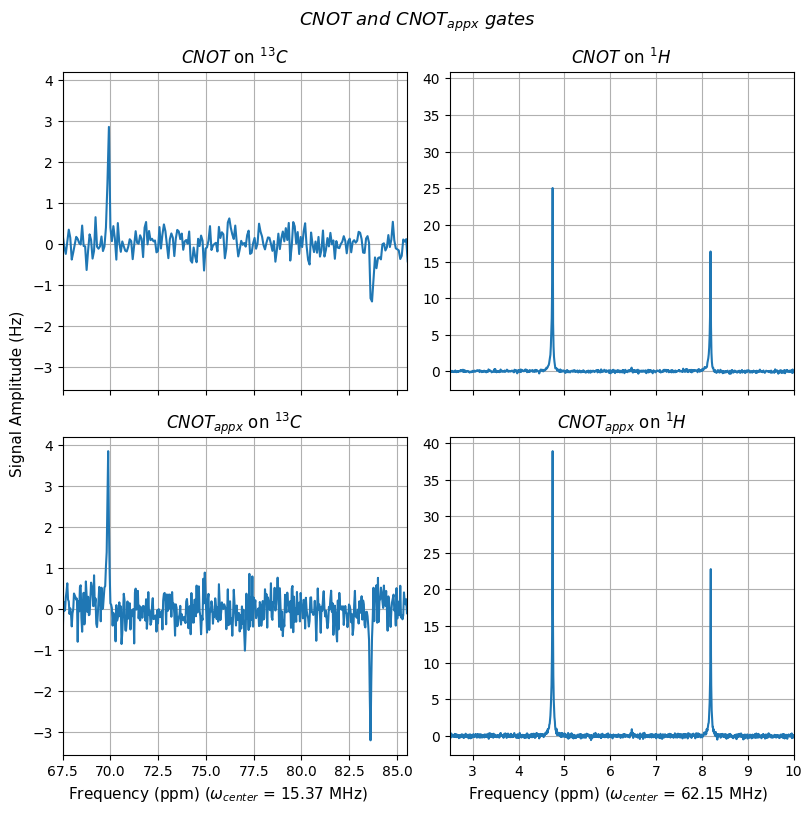

In [115]:
CNOT_1H = pd.read_csv( "/Users/shashank/Documents/NMR/Tests/CNOT_1H.csv", header = None)
CNOT_13C = pd.read_csv( "/Users/shashank/Documents/NMR/Tests/CNOT_13C.csv", header = None)
CNOTappx_1H = pd.read_csv( "/Users/shashank/Documents/NMR/Tests/CNOT_appx_1H.csv", header = None)
CNOTappx_13C = pd.read_csv( "/Users/shashank/Documents/NMR/Tests/CNOT_appx_13C.csv", header = None)

freq_1H = np.array(CNOT_1H.iloc[:,0])
spec_1H = np.array(CNOT_1H.iloc[:,1])
freq_13C = np.array(CNOT_13C.iloc[:,0])
spec_13C = np.array(CNOT_13C.iloc[:,1])

freqappx_1H = np.array(CNOTappx_1H.iloc[:,0])
specappx_1H = np.array(CNOTappx_1H.iloc[:,1])
freqappx_13C = np.array(CNOTappx_13C.iloc[:,0])
specappx_13C = np.array(CNOTappx_13C.iloc[:,1])

plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(2,2, sharex = 'col', sharey = 'col', figsize = (8,8))
fig.suptitle('$CNOT$ and $CNOT_{appx}$ gates', fontsize=13, style = 'italic') 
ax[0,0].plot(freq_13C, spec_13C)
ax[0,0].title.set_text("$CNOT$ on $^{13}C$ ")
ax[0,0].set_xlim(67.5, 85.5)
ax[0,1].plot(freq_1H, spec_1H)
ax[0,1].set_xlim(2.5, 10)
ax[0,1].title.set_text("$CNOT$ on $^{1}H$ ")
ax[1,0].plot(freqappx_13C, specappx_13C)
ax[1,0].title.set_text("$CNOT_{appx}$ on $^{13}C$ ")
ax[1,1].plot(freqappx_1H, specappx_1H)
ax[1,1].title.set_text("$CNOT_{appx}$ on $^{1}H$ ")

fig.text(0.25, 0, 'Frequency (ppm) ($\omega_{center}$ = 15.37 MHz)', ha='center', va='center', fontsize = 11)
fig.text(0.75, 0, 'Frequency (ppm) ($\omega_{center}$ = 62.15 MHz)', ha='center', va='center', fontsize = 11)
fig.text(0, 0.5, 'Signal Amplitude (Hz)', ha='center', va='center', rotation='vertical', fontsize = 11)
fig.tight_layout()
plt.show()

Immediate Comments

CNOT approximate has a smaller circuit depth than Exact CNOT. The spectrum has a higher amplitude or CNOT approximate because of a shorter circuit depth and the operations does not require any composite Z pulses compared to the exact CNOT. The pulse calibration for the Carbon pulse results in incorrect ratios for the Carbon spectrum, additionally it is more susceptible to noise because the amplitude is very low

## Integrator Function

In [3]:
def integrator(xdat, ydat, min, max, thresh = 0.4):
    #Finding Peaks
    xtrim= xdat[(xdat >=min) & (xdat<=max)]
    ytrim = ydat[(xdat >=min) & (xdat<=max)]
    indices, props = snr.find_peaks(np.abs(ytrim), 
                                height = thresh*np.max(np.abs(ytrim)))
    #Arbitrary range to integrate over
    integrals = [(np.trapz(ytrim[i-35:i+35], xtrim[i-35:i+35])) for i in indices]
    return np.array(xtrim[indices]), np.array(integrals)

np.set_printoptions(precision = 3)

$$HS_{dist} = \sqrt{1 - \frac{1}{2^{2n}}\left(Tr\left(U^{\dagger}V\right)\right)^{2}}$$

In [22]:
def Fidelity (Matrix_1, Matrix_2):
    Diff = Matrix_1 - Matrix_2
    Square = np.square(Diff)
    Sum_Sqr = np.sum(Square)
    Dist = np.sqrt(Sum_Sqr)
    return Dist

In [26]:
before_dm = np.matrix([[0.5, 0, 0, 0],
                       [0, 0.3, 0, 0],
                       [0, 0, -0.3, 0],
                       [0, 0, 0, -0.5]])

after_dm = np.matrix([[0.5, 0, 0, 0],
                       [0, 0.3, 0, 0],
                       [0, 0, -0.5, 0],
                       [0, 0, 0, -0.3]])

## Temporal Averaging

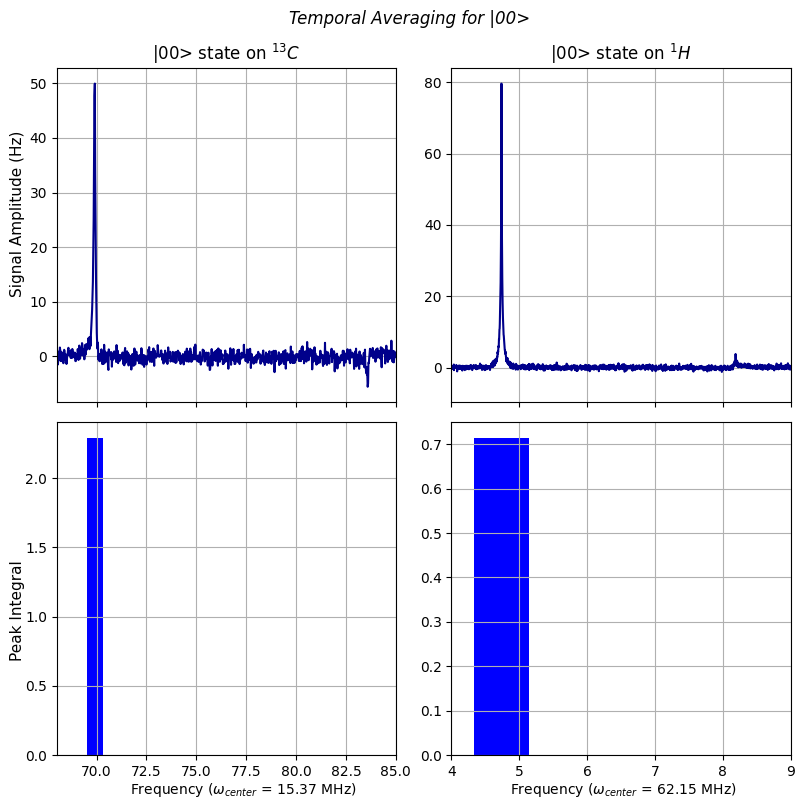

In [5]:
PATH = "/Users/shashank/Documents/NMR/TempAvg/"

fileNames = os.listdir(PATH)
fileNames_1H = [file for file in fileNames if '1H.csv' in file]
fileNames_13C = [file for file in fileNames if '13C.csv' in file]

df_1H_list = []
for i, file in enumerate(fileNames_1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_1H_list.append(df)

df_13C_list = []
for i, file in enumerate(fileNames_13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_13C_list.append(df)

sum_1H = 0
for df in df_1H_list:
    freq_1H = df.iloc[:,0]
    sum_1H += df.iloc[:,1]

sum_13C = 0
for df in df_13C_list:
    freq_13C = df.iloc[:,0]
    sum_13C += df.iloc[:,1]

peak_loc_1H, int_1H = integrator(np.array(freq_1H), np.array(sum_1H)/3, 3, 10)
peak_loc_13C, int_13C = integrator(np.array(freq_13C), np.array(sum_13C)/3, 68, 89)

plt.rcParams['axes.grid'] = True
fig, axs = plt.subplots(2, 2, sharex = 'col', figsize=(8, 8))

fig.suptitle('Temporal Averaging for |00>', style = 'italic')
fig.text(0.15, 0, 'Frequency ($\omega_{center}$ = 15.37 MHz)', fontsize = 10)
fig.text(0.625, 0, 'Frequency ($\omega_{center}$ = 62.15 MHz)', fontsize = 10)
fig.text(0, 0.17, 'Peak Integral', rotation='vertical', fontsize = 11)
fig.text(0, 0.625, 'Signal Amplitude (Hz)', rotation='vertical', fontsize = 11)

axs[0, 0].set_xlim(68, 85)
axs[0, 0].plot(freq_13C, sum_13C, color='darkblue')
axs[0, 0].set_title('|00> state on $^{13}C$')

axs[0, 1].set_xlim(4, 9)
axs[0, 1].plot(freq_1H, sum_1H, color='darkblue')
axs[0, 1].set_title('|00> state on $^{1}H$')

axs[1, 0].bar(peak_loc_13C, int_13C, color='blue')
axs[1, 1].bar(peak_loc_1H, int_1H, color='blue')

fig.tight_layout()
plt.show()

## Overcomplete Tomography

### Approx CNOT

#### Spectrum

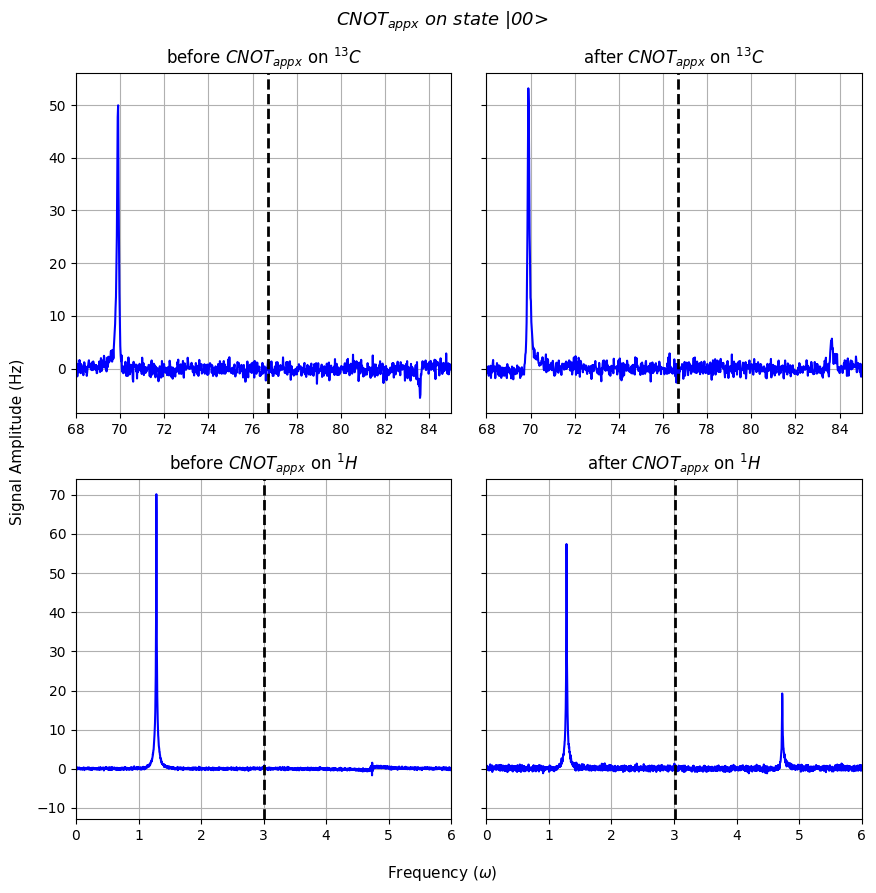

In [103]:
PATH = "/Users/shashank/Documents/NMR/Tomography/Approximate/"

fileNames = os.listdir(PATH)
fileNames_1H = [file for file in fileNames if 'None_00.csv' in file]
fileNames_a1H = [file for file in fileNames if 'CNOTappx_00.csv' in file]
fileNames_13C = [file for file in fileNames if 'None_13C.csv' in file]
fileNames_a13C = [file for file in fileNames if 'CNOTappx_13C.csv' in file]

df_1H_list = []
for i, file in enumerate(fileNames_1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_1H_list.append(df)

df_a1H_list = []
for i, file in enumerate(fileNames_a1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_a1H_list.append(df)

df_13C_list = []
for i, file in enumerate(fileNames_13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_13C_list.append(df)

df_a13C_list = []
for i, file in enumerate(fileNames_a13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_a13C_list.append(df)

sum_1H = 0
for df in df_1H_list:
    freq_1H = df.iloc[:,0]
    sum_1H += df.iloc[:,1]

sum_a1H = 0
for df in df_a1H_list:
    freq_a1H = df.iloc[:,0]
    sum_a1H += df.iloc[:,1]

sum_13C = 0
for df in df_13C_list:
    freq_13C = df.iloc[:,0]
    sum_13C += df.iloc[:,1]

sum_a13C = 0
for df in df_a13C_list:
    freq_a13C = df.iloc[:,0]
    sum_a13C += df.iloc[:,1]

peak_loc_1H, int_1H = integrator(np.array(freq_1H), np.array(sum_1H)/3, 0, 6)
peak_loc_a1H, int_a1H = integrator(np.array(freq_a1H), np.array(sum_a1H)/3, 0, 6, 0.7)
peak_loc_13C, int_13C = integrator(np.array(freq_13C), np.array(sum_13C)/3, 68, 89)
peak_loc_a13C, int_a13C = integrator(np.array(freq_a13C), np.array(sum_a13C)/3, 68, 89)

plt.rcParams['axes.grid'] = True
fig1, ax1 = plt.subplots(2, 2, sharex = 'row', sharey = 'row', figsize = (9,9))
fig1.suptitle('$CNOT_{appx}$ on state |00>', fontsize=13, style = 'italic') 
fig1.supxlabel('Frequency ($\omega$)', fontsize = 11)
fig1.supylabel('Signal Amplitude (Hz)', fontsize = 11)

ax1[0,0].set_xlim(68, 85)
ax1[0,0].plot(freq_13C, sum_13C, color = 'blue')
ax1[0,0].axvline(x = 76.7, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[0,0].set_title('before $CNOT_{appx}$ on $^{13}C$')
ax1[0,1].plot(freq_a13C, sum_a13C, color = 'blue')
ax1[0,1].axvline(x = 76.7, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[0,1].set_title('after $CNOT_{appx}$ on $^{13}C $')

ax1[1,0].set_xlim(0, 6)
ax1[1,0].plot(freq_1H, sum_1H, color = 'blue')
ax1[1,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[1,0].set_title('before $CNOT_{appx}$ on $^{1}H$')
ax1[1,1].plot(freq_a1H, sum_a1H, color = 'blue')
ax1[1,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[1,1].set_title('after $CNOT_{appx}$ on $^{1}H$')

fig1.tight_layout()
plt.show()

#### Integrals

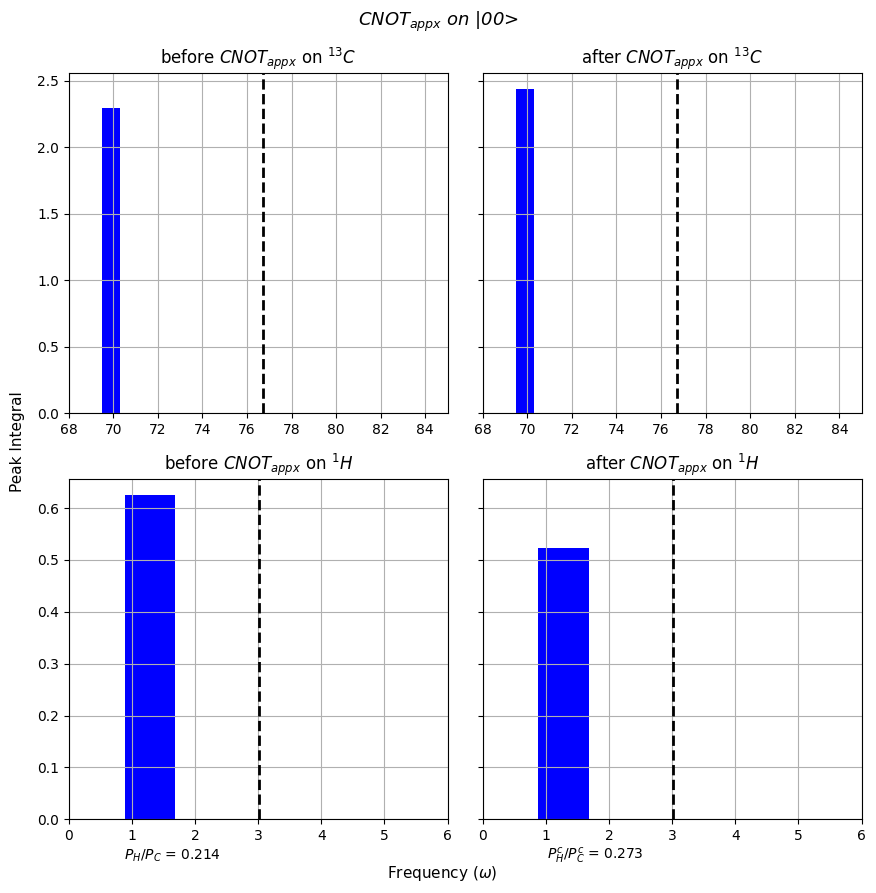

In [104]:
PATH = "/Users/shashank/Documents/NMR/Tomography/Approximate/"

fileNames = os.listdir(PATH)
fileNames_1H = [file for file in fileNames if 'None_00.csv' in file]
fileNames_a1H = [file for file in fileNames if 'CNOTappx_00.csv' in file]
fileNames_13C = [file for file in fileNames if 'None_13C.csv' in file]
fileNames_a13C = [file for file in fileNames if 'CNOTappx_13C.csv' in file]

df_1H_list = []
for i, file in enumerate(fileNames_1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_1H_list.append(df)

df_a1H_list = []
for i, file in enumerate(fileNames_a1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_a1H_list.append(df)

df_13C_list = []
for i, file in enumerate(fileNames_13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_13C_list.append(df)

df_a13C_list = []
for i, file in enumerate(fileNames_a13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_a13C_list.append(df)

sum_1H = 0
for df in df_1H_list:
    freq_1H = df.iloc[:,0]
    sum_1H += df.iloc[:,1]

sum_a1H = 0
for df in df_a1H_list:
    freq_a1H = df.iloc[:,0]
    sum_a1H += df.iloc[:,1]

sum_13C = 0
for df in df_13C_list:
    freq_13C = df.iloc[:,0]
    sum_13C += df.iloc[:,1]

sum_a13C = 0
for df in df_a13C_list:
    freq_a13C = df.iloc[:,0]
    sum_a13C += df.iloc[:,1]

peak_loc_1H, int_1H = integrator(np.array(freq_1H), np.array(sum_1H)/3, 0, 6)
peak_loc_a1H, int_a1H = integrator(np.array(freq_a1H), np.array(sum_a1H)/3, 0, 6, 0.7)
peak_loc_13C, int_13C = integrator(np.array(freq_13C), np.array(sum_13C)/3, 68, 89)
peak_loc_a13C, int_a13C = integrator(np.array(freq_a13C), np.array(sum_a13C)/3, 68, 89)

ratio_a = int_1H[0]/int_13C[0]
ratio_b = int_a1H[0]/int_a13C[0]

plt.rcParams['axes.grid'] = True
fig1, ax1 = plt.subplots(2, 2, sharex = 'row', sharey = 'row', figsize = (9,9))
fig1.suptitle('$CNOT_{appx}$ on |00>  ', fontsize=13, style = 'italic') 
fig1.supxlabel('Frequency ($\omega$)', fontsize = 11)
fig1.supylabel('Peak Integral', fontsize = 11)

ax1[0,0].set_xlim(68, 85)
ax1[0,0].bar(peak_loc_13C, int_13C, color = 'blue')
ax1[0,0].axvline(x = 76.7, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[0,0].set_title('before $CNOT_{appx}$ on $^{13}C$')
ax1[0,1].bar(peak_loc_a13C, int_a13C, color = 'blue')
ax1[0,1].axvline(x = 76.7, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[0,1].set_title('after $CNOT_{appx}$ on $^{13}C $')

ax1[1,0].set_xlim(0, 6)
ax1[1,0].bar(peak_loc_1H, int_1H, color = 'blue')
ax1[1,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[1,0].set_title('before $CNOT_{appx}$ on $^{1}H$')
ax1[1,1].bar(peak_loc_a1H, int_a1H, color = 'blue')
ax1[1,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[1,1].set_title('after $CNOT_{appx}$ on $^{1}H$')

fig1.text(0.20, 0.04, f'$P_H/P_C$ = {ratio_b:.3g}', ha='center', va='center', fontsize = 10)
fig1.text(0.67, 0.04, f'$P^c_H/P^c_C$ = {ratio_a:.3g}', ha='center', va='center', fontsize = 10)
fig1.tight_layout()
plt.show()

### Exact CNOT

#### Spectrum

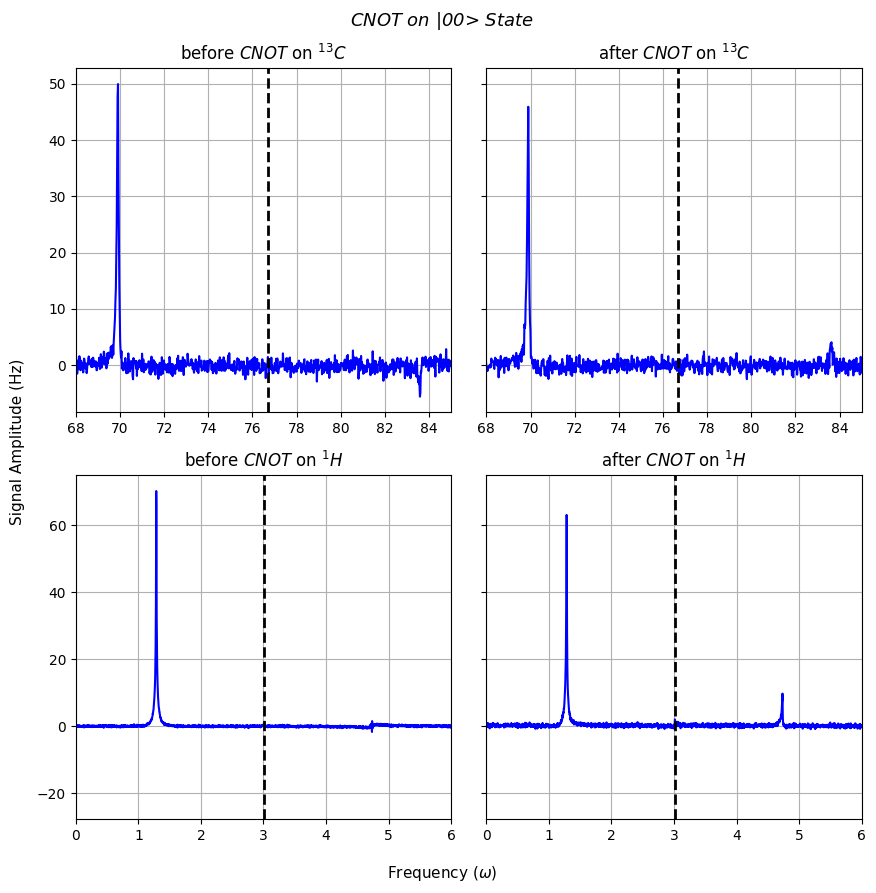

In [105]:
PATH = "/Users/shashank/Documents/NMR/Tomography/Exact/"

fileNames = os.listdir(PATH)
fileNames_1H = [file for file in fileNames if 'None_00.csv' in file]
fileNames_a1H = [file for file in fileNames if 'CNOT_00.csv' in file]
fileNames_13C = [file for file in fileNames if 'None_13C.csv' in file]
fileNames_a13C = [file for file in fileNames if 'CNOT_13C.csv' in file]

df_1H_list = []
for i, file in enumerate(fileNames_1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_1H_list.append(df)

df_a1H_list = []
for i, file in enumerate(fileNames_a1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_a1H_list.append(df)

df_13C_list = []
for i, file in enumerate(fileNames_13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_13C_list.append(df)

df_a13C_list = []
for i, file in enumerate(fileNames_a13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_a13C_list.append(df)

sum_1H = 0
for df in df_1H_list:
    freq_1H = df.iloc[:,0]
    sum_1H += df.iloc[:,1]

sum_a1H = 0
for df in df_a1H_list:
    freq_a1H = df.iloc[:,0]
    sum_a1H += df.iloc[:,1]

sum_13C = 0
for df in df_13C_list:
    freq_13C = df.iloc[:,0]
    sum_13C += df.iloc[:,1]

sum_a13C = 0
for df in df_a13C_list:
    freq_a13C = df.iloc[:,0]
    sum_a13C += df.iloc[:,1]

peak_loc_1H, int_1H = integrator(np.array(freq_1H), np.array(sum_1H)/3, 0, 6)
peak_loc_a1H, int_a1H = integrator(np.array(freq_a1H), np.array(sum_a1H)/3, 0, 6, 0.7)
peak_loc_13C, int_13C = integrator(np.array(freq_13C), np.array(sum_13C)/3, 68, 89)
peak_loc_a13C, int_a13C = integrator(np.array(freq_a13C), np.array(sum_a13C)/3, 68, 89)

ratio_b = int_1H/int_13C
ratio_a = int_a1H/int_a13C

plt.rcParams['axes.grid'] = True
fig1, ax1 = plt.subplots(2, 2, sharex = 'row', sharey = 'row', figsize = (9,9))
fig1.suptitle('$CNOT$ on |00> State', fontsize=13, style = 'italic') 
fig1.supxlabel('Frequency ($\omega$)', fontsize = 11)
fig1.supylabel('Signal Amplitude (Hz)', fontsize = 11)

ax1[0,0].set_xlim(68, 85)
ax1[0,0].plot(freq_13C, sum_13C, color = 'blue')
ax1[0,0].axvline(x = 76.7, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[0,0].set_title('before $CNOT$ on $^{13}C$')
ax1[0,1].plot(freq_a13C, sum_a13C, color = 'blue')
ax1[0,1].axvline(x = 76.7, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[0,1].set_title('after $CNOT$ on $^{13}C $')

ax1[1,0].set_xlim(0, 6)
ax1[1,0].plot(freq_1H, sum_1H, color = 'blue')
ax1[1,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[1,0].set_title('before $CNOT$ on $^{1}H$')
ax1[1,1].plot(freq_a1H, sum_a1H, color = 'blue')
ax1[1,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[1,1].set_title('after $CNOT$ on $^{1}H$')

fig1.tight_layout()
plt.show()

#### Integrals

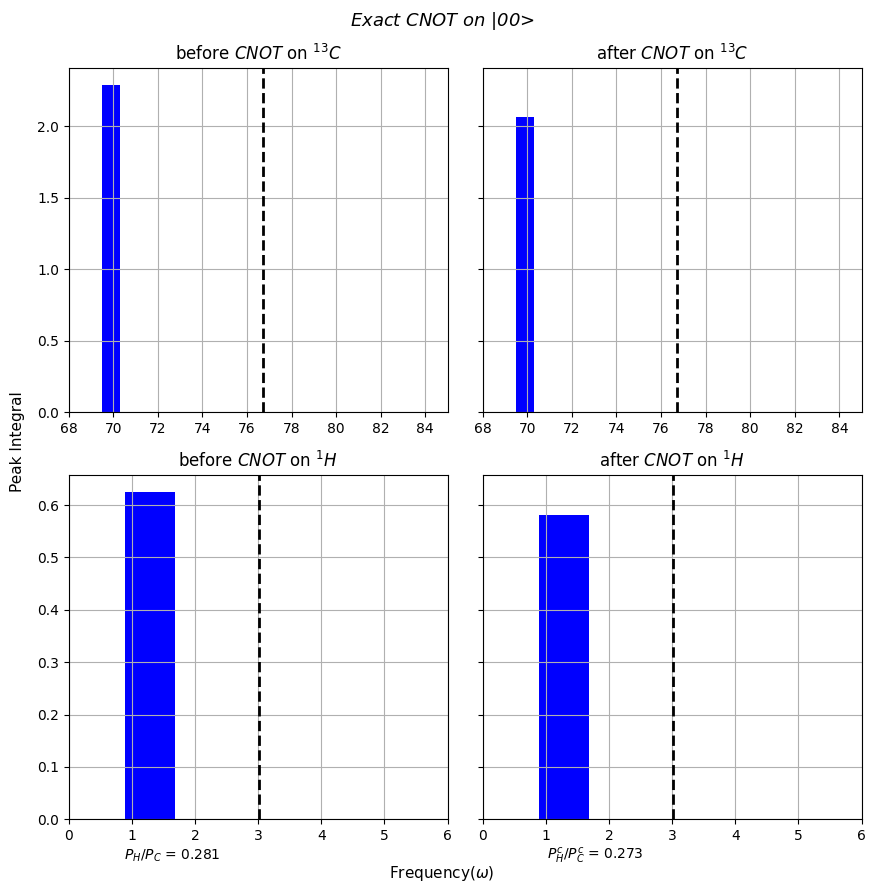

In [106]:
PATH = "/Users/shashank/Documents/NMR/Tomography/Exact/"

fileNames = os.listdir(PATH)
fileNames_1H = [file for file in fileNames if 'None_00.csv' in file]
fileNames_a1H = [file for file in fileNames if 'CNOT_00.csv' in file]
fileNames_13C = [file for file in fileNames if 'None_13C.csv' in file]
fileNames_a13C = [file for file in fileNames if 'CNOT_13C.csv' in file]

df_1H_list = []
for i, file in enumerate(fileNames_1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_1H_list.append(df)

df_a1H_list = []
for i, file in enumerate(fileNames_a1H):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_a1H_list.append(df)

df_13C_list = []
for i, file in enumerate(fileNames_13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_13C_list.append(df)

df_a13C_list = []
for i, file in enumerate(fileNames_a13C):
    df = pd.read_csv(PATH + file, header=None, usecols=[0, 1])
    df_a13C_list.append(df)

sum_1H = 0
for df in df_1H_list:
    freq_1H = df.iloc[:,0]
    sum_1H += df.iloc[:,1]

sum_a1H = 0
for df in df_a1H_list:
    freq_a1H = df.iloc[:,0]
    sum_a1H += df.iloc[:,1]

sum_13C = 0
for df in df_13C_list:
    freq_13C = df.iloc[:,0]
    sum_13C += df.iloc[:,1]

sum_a13C = 0
for df in df_a13C_list:
    freq_a13C = df.iloc[:,0]
    sum_a13C += df.iloc[:,1]

peak_loc_1H, int_1H = integrator(np.array(freq_1H), np.array(sum_1H)/3, 0, 6)
peak_loc_a1H, int_a1H = integrator(np.array(freq_a1H), np.array(sum_a1H)/3, 0, 6)
peak_loc_13C, int_13C = integrator(np.array(freq_13C), np.array(sum_13C)/3, 68, 89)
peak_loc_a13C, int_a13C = integrator(np.array(freq_a13C), np.array(sum_a13C)/3, 68, 89)

ratio_a = int_1H[0]/int_13C[0]
ratio_b = int_a1H[0]/int_a13C[0]

plt.rcParams['axes.grid'] = True
fig1, ax1 = plt.subplots(2, 2, sharex = 'row', sharey = 'row', figsize = (9,9))
fig1.suptitle('Exact $CNOT$ on |00>', fontsize=13, style = 'italic') 
fig1.supxlabel('Frequency($\omega$)', fontsize = 11)
fig1.supylabel('Peak Integral', fontsize = 11)

ax1[0,0].set_xlim(68, 85)
ax1[0,0].bar(peak_loc_13C, int_13C, color = 'blue')
ax1[0,0].axvline(x = 76.7, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[0,0].set_title('before $CNOT$ on $^{13}C$')
ax1[0,1].bar(peak_loc_a13C, int_a13C, color = 'blue')
ax1[0,1].axvline(x = 76.7, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[0,1].set_title('after $CNOT$ on $^{13}C $')

ax1[1,0].set_xlim(0, 6)
ax1[1,0].bar(peak_loc_1H, int_1H, color = 'blue')
ax1[1,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[1,0].set_title('before $CNOT$ on $^{1}H$')
ax1[1,1].bar(peak_loc_a1H, int_a1H, color = 'blue')
ax1[1,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 2, color = 'black')
ax1[1,1].set_title('after $CNOT$ on $^{1}H$')

fig1.text(0.20, 0.04, f'$P_H/P_C$ = {ratio_b:.3g}', ha='center', va='center', fontsize = 10)
fig1.text(0.67, 0.04, f'$P^c_H/P^c_C$ = {ratio_a:.3g}', ha='center', va='center', fontsize = 10)
fig1.tight_layout()
plt.show()

## CNOT

### Truth Table for CNOT

#### Spectrum

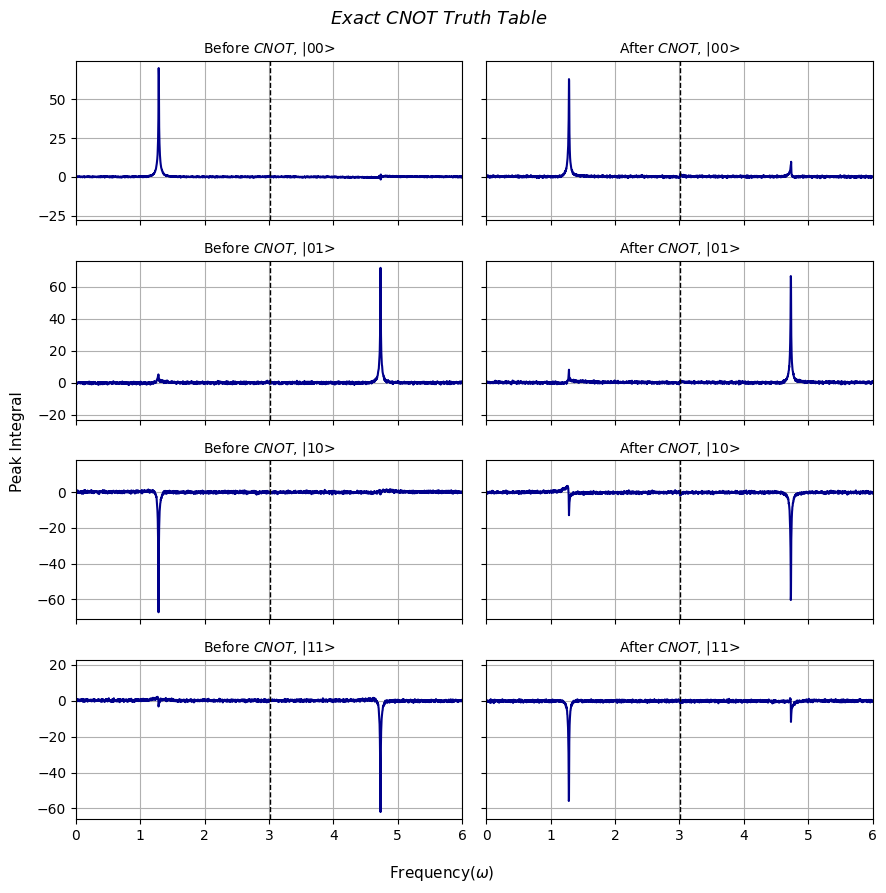

In [107]:
PATH = "/Users/shashank/Documents/NMR/CNOT_TruthTable/"
states = ['00', '01', '10', '11']
clist  = ['blue', 'darkorange', 'cyan', 'purple']
clist_a  = ['blue', 'darkorange', 'purple', 'cyan']
n_files = len(states)
locs_before = []
locs_after  = []
ints_before = []
ints_after  = []

for j in range(n_files):
    complete_path = PATH + states[j] + '/'
    before = 'None_' + states[j] + '.csv'
    after = 'CNOT_' + states[j] + '.csv'

    fileNames = os.listdir(complete_path)
    fileNames_before = [file for file in fileNames if before in file]
    fileNames_after = [file for file in fileNames if after in file]

    df_before_list = []
    for i, file in enumerate(fileNames_before):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_before_list.append(df)

    df_after_list = []
    for i, file in enumerate(fileNames_after):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_after_list.append(df)

    sum_before = 0
    for df in df_before_list:
        freq_before = df.iloc[:,0]
        sum_before += df.iloc[:,1]

    sum_after = 0
    for df in df_after_list:
        freq_after = df.iloc[:,0]
        sum_after += df.iloc[:,1]

    peak_loc_before, int_before = integrator(np.array(freq_before), np.array(sum_before)/3, 0, 6)
    peak_loc_after, int_after = integrator(np.array(freq_after), np.array(sum_after)/3, 0, 6)

    locs_before.append(freq_before)
    locs_after.append(freq_after)
    ints_before.append(sum_before)
    ints_after.append(sum_after)


plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(n_files, 2, sharex = 'all', sharey = 'row', figsize = (9,9))
fig.suptitle('Exact $CNOT$ Truth Table  ', fontsize=13, style = 'italic') 
fig.supxlabel('Frequency($\omega$)', fontsize = 11)
fig.supylabel('Peak Integral', fontsize = 11)

for n in range(n_files):
    ax[n,0].set_xlim(0, 6)
    ax[n,0].plot(locs_before[n], ints_before[n], color = 'darkblue')
    ax[n,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
    ax[n,0].set_title(f"Before $CNOT$, |{states[n]}>", size = 10)
    ax[n,1].plot(locs_after[n], ints_after[n], color = 'darkblue')
    ax[n,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
    ax[n,1].set_title(f"After $CNOT$, |{states[n]}>", size = 10)

fig.tight_layout()
plt.show()

#### Integrals

[[ 0.625  0.     0.     0.   ]
 [ 0.     0.59   0.     0.   ]
 [ 0.     0.    -0.428  0.   ]
 [ 0.     0.     0.    -0.416]]
[[ 0.581  0.     0.     0.   ]
 [ 0.     0.589  0.     0.   ]
 [ 0.     0.    -0.514  0.   ]
 [ 0.     0.     0.    -0.416]]
0.10796749103827809


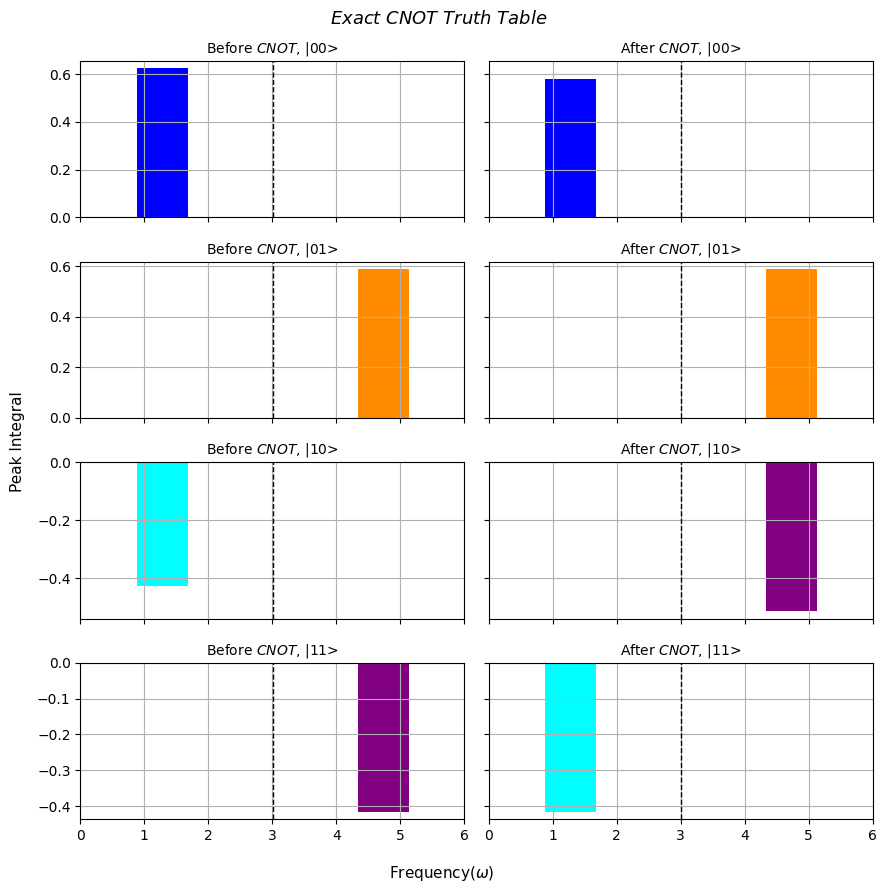

In [32]:
PATH = "/Users/shashank/Documents/NMR/CNOT_TruthTable/"
states = ['00', '01', '10', '11']
clist  = ['blue', 'darkorange', 'cyan', 'purple']
clist_a  = ['blue', 'darkorange', 'purple', 'cyan']
n_files = len(states)
locs_before = []
locs_after  = []
ints_before = []
ints_after  = []

for j in range(n_files):
    complete_path = PATH + states[j] + '/'
    before ='None_' + states[j] + '.csv'
    after = 'CNOT_' + states[j] + '.csv'

    fileNames = os.listdir(complete_path)
    fileNames_before = [file for file in fileNames if before in file]
    fileNames_after = [file for file in fileNames if after in file]

    df_before_list = []
    for i, file in enumerate(fileNames_before):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_before_list.append(df)

    df_after_list = []
    for i, file in enumerate(fileNames_after):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_after_list.append(df)

    sum_before = 0
    for df in df_before_list:
        freq_before = df.iloc[:,0]
        sum_before += df.iloc[:,1]

    sum_after = 0
    for df in df_after_list:
        freq_after = df.iloc[:,0]
        sum_after += df.iloc[:,1]

    peak_loc_before, int_before = integrator(np.array(freq_before), np.array(sum_before)/3, 0, 6)
    peak_loc_after, int_after = integrator(np.array(freq_after), np.array(sum_after)/3, 0, 6)

    locs_before.append(peak_loc_before)
    locs_after.append(peak_loc_after)
    ints_before.append(int_before)
    ints_after.append(int_after)

a = ints_before[0][0]
b = ints_before[1][0]
c = ints_before[2][0]
d = ints_before[3][0]

density_b = np.matrix([[a, 0, 0, 0],
                     [0, b, 0, 0],
                     [0, 0, c, 0],
                     [0, 0, 0, d]])
print (density_b)

compare_dm = np.matrix([[a, 0, 0, 0],
                     [0, b, 0, 0],
                     [0, 0, d, 0],
                     [0, 0, 0, c]])

a_p = ints_after[0][0]
b_p = ints_after[1][0]
c_p = ints_after[2][0]
d_p = ints_after[3][0]

density_a = np.matrix([[a_p, 0, 0, 0],
                     [0, b_p, 0, 0],
                     [0, 0, c_p, 0],
                     [0, 0, 0, d_p]])
print (density_a)
print (Fidelity(compare_dm, density_a))

plt.rcParams['axes.grid'] = True
fig1, ax1 = plt.subplots(n_files, 2, sharex = 'all', sharey = 'row', figsize = (9,9))
fig1.suptitle('Exact $CNOT$ Truth Table  ', fontsize=13, style = 'italic') 
fig1.supxlabel('Frequency($\omega$)', fontsize = 11)
fig1.supylabel('Peak Integral', fontsize = 11)

for n in range(n_files):
    ax1[n,0].set_xlim(0, 6)
    ax1[n,0].bar(locs_before[n], ints_before[n], color = clist[n])
    ax1[n,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
    ax1[n,0].set_title(f"Before $CNOT$, |{states[n]}>", size = 10)
    ax1[n,1].bar(locs_after[n], ints_after[n], color = clist_a[n])
    ax1[n,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
    ax1[n,1].set_title(f"After $CNOT$, |{states[n]}>", size = 10)

fig1.tight_layout()
plt.show()

## Approx CNOT

### Truth Table for Appx CNOT

#### Spectrum

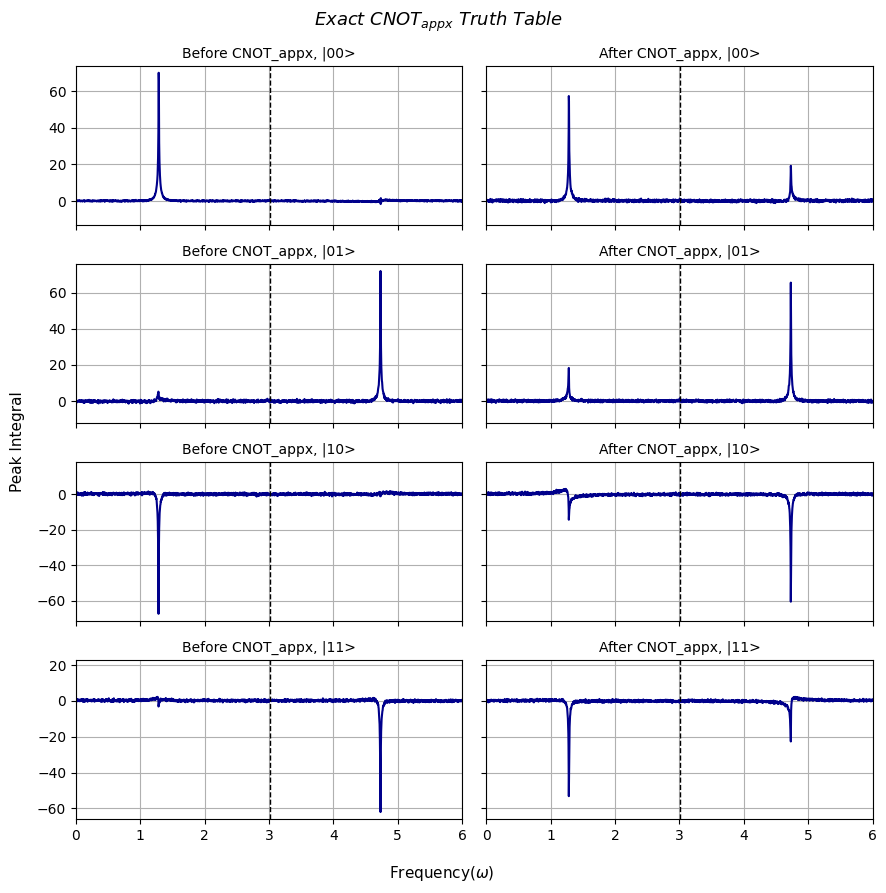

In [109]:
PATH = "/Users/shashank/Documents/NMR/CNOT_appx_TruthTable/"
states = ['00', '01', '10', '11']
clist  = ['blue', 'darkorange', 'cyan', 'purple']
clist_a  = ['blue', 'darkorange', 'purple', 'cyan']
n_files = len(states)
locs_before = []
locs_after  = []
ints_before = []
ints_after  = []

for j in range(n_files):
    complete_path = PATH + states[j] + '/'
    before = 'None_' + states[j] + '.csv'
    after = 'CNOTappx_' + states[j] + '.csv'

    fileNames = os.listdir(complete_path)
    fileNames_before = [file for file in fileNames if before in file]
    fileNames_after = [file for file in fileNames if after in file]

    df_before_list = []
    for i, file in enumerate(fileNames_before):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_before_list.append(df)

    df_after_list = []
    for i, file in enumerate(fileNames_after):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_after_list.append(df)

    sum_before = 0
    for df in df_before_list:
        freq_before = df.iloc[:,0]
        sum_before += df.iloc[:,1]

    sum_after = 0
    for df in df_after_list:
        freq_after = df.iloc[:,0]
        sum_after += df.iloc[:,1]

    peak_loc_before, int_before = integrator(np.array(freq_before), np.array(sum_before)/3, 0, 6)
    peak_loc_after, int_after = integrator(np.array(freq_after), np.array(sum_after)/3, 0, 6)

    locs_before.append(freq_before)
    locs_after.append(freq_after)
    ints_before.append(sum_before)
    ints_after.append(sum_after)


plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(n_files, 2, sharex = 'all', sharey = 'row', figsize = (9,9))
fig.suptitle('Exact $CNOT_{appx}$ Truth Table  ', fontsize=13, style = 'italic') 
fig.supxlabel('Frequency($\omega$)', fontsize = 11)
fig.supylabel('Peak Integral', fontsize = 11)

for n in range(n_files):
    ax[n,0].set_xlim(0, 6)
    ax[n,0].plot(locs_before[n], ints_before[n], color = 'darkblue')
    ax[n,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
    ax[n,0].set_title(f"Before CNOT_appx, |{states[n]}>", size = 10)
    ax[n,1].plot(locs_after[n], ints_after[n], color = 'darkblue')
    ax[n,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
    ax[n,1].set_title(f"After CNOT_appx, |{states[n]}>", size = 10)

fig.tight_layout()
plt.show()

#### Integrals

[[ 0.625  0.     0.     0.   ]
 [ 0.     0.59   0.     0.   ]
 [ 0.     0.    -0.428  0.   ]
 [ 0.     0.     0.    -0.416]]
[[ 0.523  0.     0.     0.   ]
 [ 0.     0.538  0.     0.   ]
 [ 0.     0.    -0.469  0.   ]
 [ 0.     0.     0.    -0.373]]
0.1383956424901756


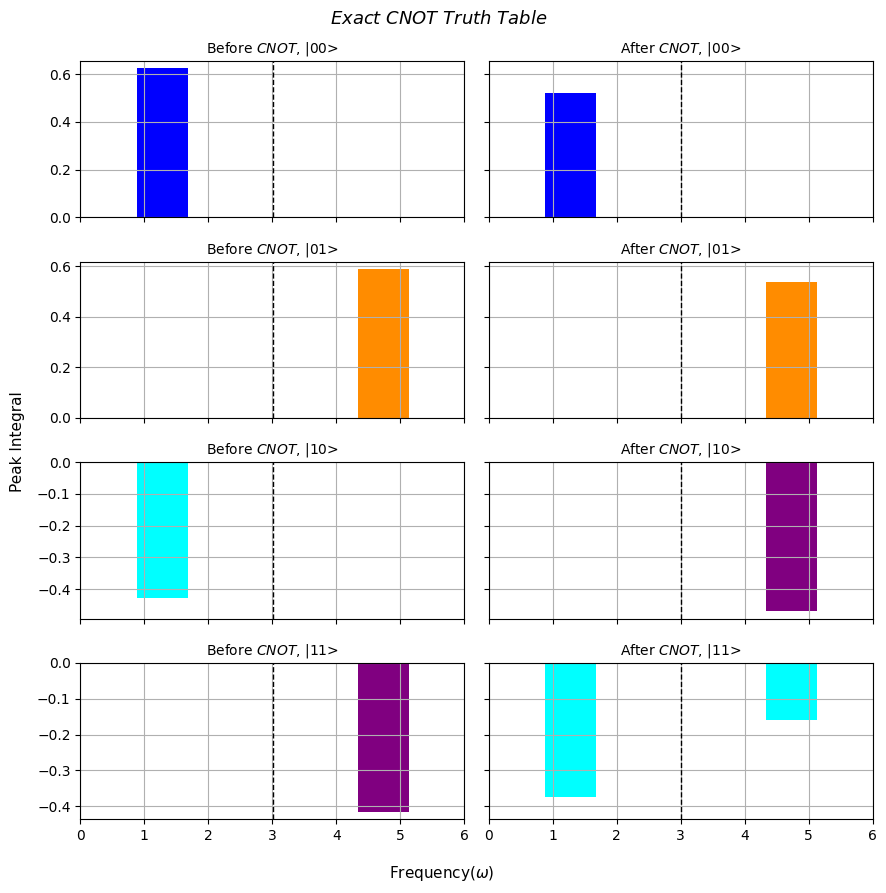

In [33]:
PATH = "/Users/shashank/Documents/NMR/CNOT_appx_TruthTable/"
states = ['00', '01', '10', '11']
clist  = ['blue', 'darkorange', 'cyan', 'purple']
clist_a  = ['blue', 'darkorange', 'purple', 'cyan']
n_files = len(states)
locs_before = []
locs_after  = []
ints_before = []
ints_after  = []

for j in range(n_files):
    complete_path = PATH + states[j] + '/'
    before ='None_' + states[j] + '.csv'
    after = 'CNOTappx_' + states[j] + '.csv'

    fileNames = os.listdir(complete_path)
    fileNames_before = [file for file in fileNames if before in file]
    fileNames_after = [file for file in fileNames if after in file]

    df_before_list = []
    for i, file in enumerate(fileNames_before):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_before_list.append(df)

    df_after_list = []
    for i, file in enumerate(fileNames_after):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_after_list.append(df)

    sum_before = 0
    for df in df_before_list:
        freq_before = df.iloc[:,0]
        sum_before += df.iloc[:,1]

    sum_after = 0
    for df in df_after_list:
        freq_after = df.iloc[:,0]
        sum_after += df.iloc[:,1]

    peak_loc_before, int_before = integrator(np.array(freq_before), np.array(sum_before)/3, 0, 6)
    peak_loc_after, int_after = integrator(np.array(freq_after), np.array(sum_after)/3, 0, 6)

    locs_before.append(peak_loc_before)
    locs_after.append(peak_loc_after)
    ints_before.append(int_before)
    ints_after.append(int_after)
    
a = ints_before[0][0]
b = ints_before[1][0]
c = ints_before[2][0]
d = ints_before[3][0]

density_b = np.array([[a, 0, 0, 0],
                     [0, b, 0, 0],
                     [0, 0, c, 0],
                     [0, 0, 0, d]])
print (density_b)

compare_dm = np.matrix([[a, 0, 0, 0],
                     [0, b, 0, 0],
                     [0, 0, d, 0],
                     [0, 0, 0, c]])

a_p = ints_after[0][0]
b_p = ints_after[1][0]
c_p = ints_after[2][0]
d_p = ints_after[3][0]

density_a = np.array([[a_p, 0, 0, 0],
                     [0, b_p, 0, 0],
                     [0, 0, c_p, 0],
                     [0, 0, 0, d_p]])
print (density_a)
print (Fidelity(compare_dm, density_a))

plt.rcParams['axes.grid'] = True
fig1, ax1 = plt.subplots(n_files, 2, sharex = 'all', sharey = 'row', figsize = (9,9))
fig1.suptitle('Exact $CNOT$ Truth Table  ', fontsize=13, style = 'italic') 
fig1.supxlabel('Frequency($\omega$)', fontsize = 11)
fig1.supylabel('Peak Integral', fontsize = 11)

for n in range(n_files):
    ax1[n,0].set_xlim(0, 6)
    ax1[n,0].bar(locs_before[n], ints_before[n], color = clist[n])
    ax1[n,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
    ax1[n,0].set_title(f"Before $CNOT$, |{states[n]}>", size = 10)
    ax1[n,1].bar(locs_after[n], ints_after[n], color = clist_a[n])
    ax1[n,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
    ax1[n,1].set_title(f"After $CNOT$, |{states[n]}>", size = 10)

fig1.tight_layout()
plt.show()

# LAB 4

## Deutsch-Jozsa Algorithm

### Truth Table

#### Spectrum

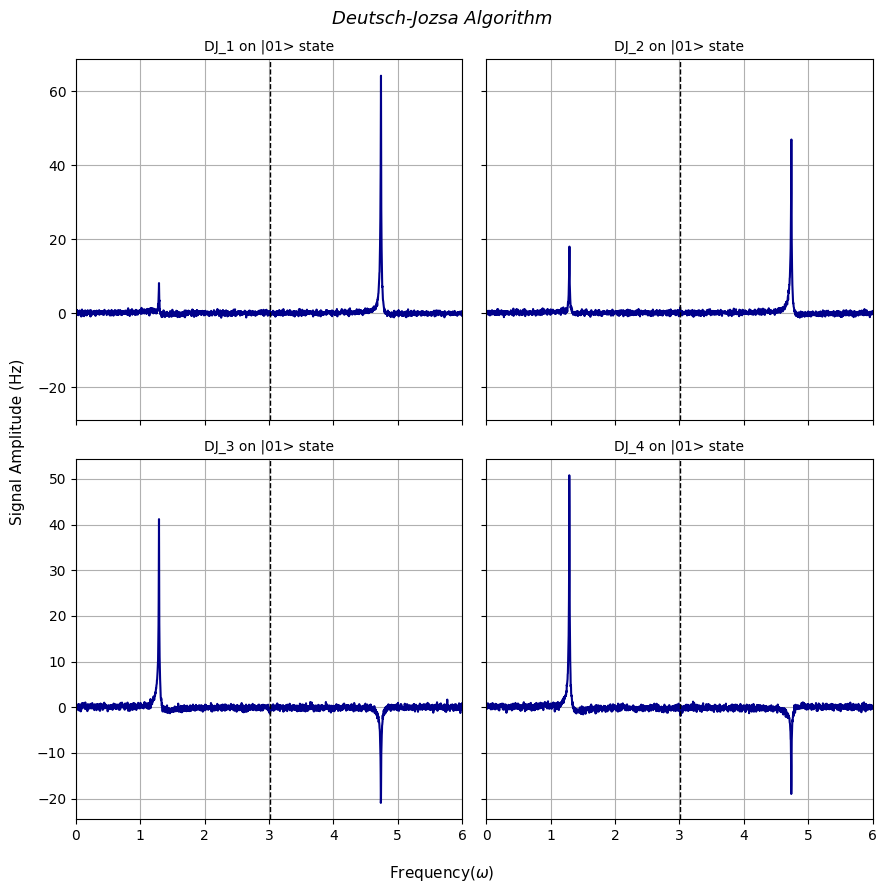

In [111]:
PATH = "/Users/shashank/Documents/NMR/Deutsch-Jozsa/"
states = ['DJ_1', 'DJ_2', 'DJ_3', 'DJ_4']
n_files = len(states)
locs = []
ints = []

for j in range(n_files):
    complete_path = PATH + states[j] + '/'

    fileNames = os.listdir(complete_path)
    fileNames_DJ = [file for file in fileNames]

    df_DJ = []
    for i, file in enumerate(fileNames_DJ):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_DJ.append(df)

    sum_DJ = 0
    for df in df_DJ:
        freq_DJ = df.iloc[:,0]
        sum_DJ += df.iloc[:,1]


    peak_loc_DJ, int_DJ = integrator(np.array(freq_DJ), np.array(sum_DJ)/3, 0, 6)

    locs.append(freq_DJ)
    ints.append(sum_DJ)


plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(2, 2, sharex = 'all', sharey = 'row', figsize = (9,9))
fig.suptitle('Deutsch-Jozsa Algorithm', fontsize=13, style = 'italic') 
fig.supxlabel('Frequency($\omega$)', fontsize = 11)
fig.supylabel('Signal Amplitude (Hz)', fontsize = 11)

ax[0,0].set_xlim(0, 6)
ax[0,0].plot(locs[0], ints[0], color = 'darkblue')
ax[0,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[0,0].set_title(f"{states[0]} on |01> state", size = 10)

ax[0,1].plot(locs[1], ints[1], color = 'darkblue')
ax[0,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[0,1].set_title(f"{states[1]} on |01> state", size = 10)

ax[1,0].plot(locs[2], ints[2], color = 'darkblue')
ax[1,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[1,0].set_title(f"{states[2]} on |01> state", size = 10)

ax[1,1].plot(locs[3], ints[3], color = 'darkblue')
ax[1,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[1,1].set_title(f"{states[3]} on |01> state", size = 10)

fig.tight_layout()
plt.show()

#### Integrals

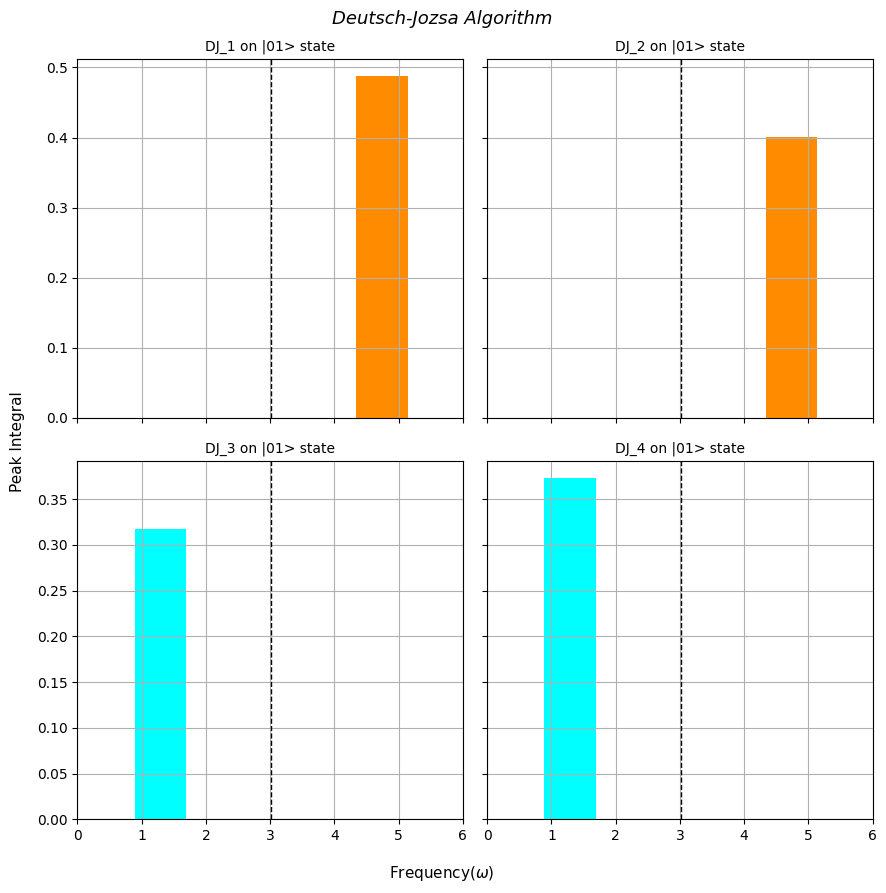

In [112]:
PATH = "/Users/shashank/Documents/NMR/Deutsch-Jozsa/"
states = ['DJ_1', 'DJ_2', 'DJ_3', 'DJ_4']
n_files = len(states)
locs = []
ints = []

for j in range(n_files):
    complete_path = PATH + states[j] + '/'

    fileNames = os.listdir(complete_path)
    fileNames_DJ = [file for file in fileNames]

    df_DJ = []
    for i, file in enumerate(fileNames_DJ):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_DJ.append(df)

    sum_DJ = 0
    for df in df_DJ:
        freq_DJ = df.iloc[:,0]
        sum_DJ += df.iloc[:,1]


    peak_loc_DJ, int_DJ = integrator(np.array(freq_DJ), np.array(sum_DJ)/3, 0, 6, 0.8)

    locs.append(peak_loc_DJ)
    ints.append(int_DJ)


plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(2, 2, sharex = 'all', sharey = 'row', figsize = (9,9))
fig.suptitle('Deutsch-Jozsa Algorithm', fontsize=13, style = 'italic') 
fig.supxlabel('Frequency($\omega$)', fontsize = 11)
fig.supylabel('Peak Integral', fontsize = 11)

ax[0,0].set_xlim(0, 6)
ax[0,0].bar(locs[0], ints[0], color = 'darkorange')
ax[0,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[0,0].set_title(f"{states[0]} on |01> state", size = 10)

ax[0,1].bar(locs[1], ints[1], color = 'darkorange')
ax[0,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[0,1].set_title(f"{states[1]} on |01> state", size = 10)

ax[1,0].bar(locs[2], ints[2], color = 'cyan')
ax[1,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[1,0].set_title(f"{states[2]} on |01> state", size = 10)

ax[1,1].bar(locs[3], ints[3], color = 'cyan')
ax[1,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[1,1].set_title(f"{states[3]} on |01> state", size = 10)

fig.tight_layout()
plt.show()

## Grover's Algorithm

### Truth Table

#### Spectrum

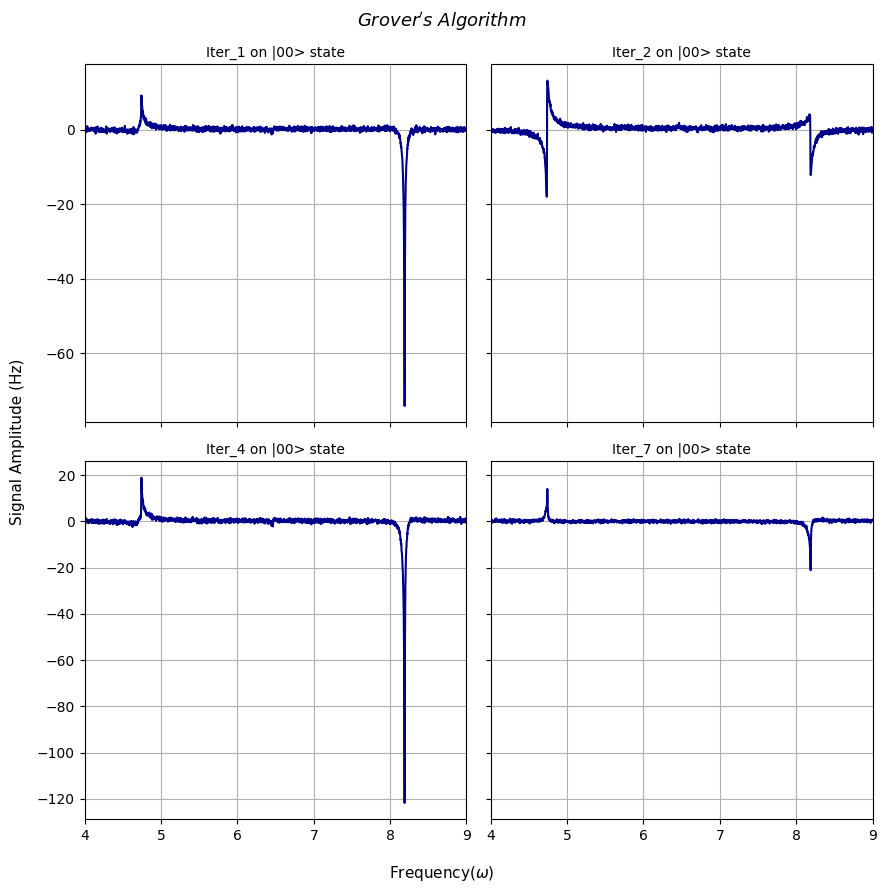

In [113]:
PATH = "/Users/shashank/Documents/NMR/Grover_s/"
states = ['Iter_1', 'Iter_2', 'Iter_4', 'Iter_7']
n_files = len(states)
locs = []
ints = []

for j in range(n_files):
    complete_path = PATH + states[j] + '/'

    fileNames = os.listdir(complete_path)
    fileNames_G = [file for file in fileNames]

    df_G = []
    for i, file in enumerate(fileNames_G):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_G.append(df)

    sum_G = 0
    for df in df_G:
        freq_G = df.iloc[:,0]
        sum_G += df.iloc[:,1]


    peak_loc_G, int_G = integrator(np.array(freq_G), np.array(sum_G)/3, 4, 9)

    locs.append(freq_G)
    ints.append(sum_G)


plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(2, 2, sharex = 'all', sharey = 'row', figsize = (9,9))
fig.suptitle('Grover$\'$s Algorithm', fontsize=13, style = 'italic') 
fig.supxlabel('Frequency($\omega$)', fontsize = 11)
fig.supylabel('Signal Amplitude (Hz)', fontsize = 11)

ax[0,0].set_xlim(4, 9)
ax[0,0].plot(locs[0], ints[0], color = 'darkblue')
ax[0,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[0,0].set_title(f"{states[0]} on |00> state", size = 10)

ax[0,1].plot(locs[1], ints[1], color = 'darkblue')
ax[0,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[0,1].set_title(f"{states[1]} on |00> state", size = 10)

ax[1,0].plot(locs[2], ints[2], color = 'darkblue')
ax[1,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[1,0].set_title(f"{states[2]} on |00> state", size = 10)

ax[1,1].plot(locs[3], ints[3], color = 'darkblue')
ax[1,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[1,1].set_title(f"{states[3]} on |00> state", size = 10)

fig.tight_layout()
plt.show()

#### Integrals

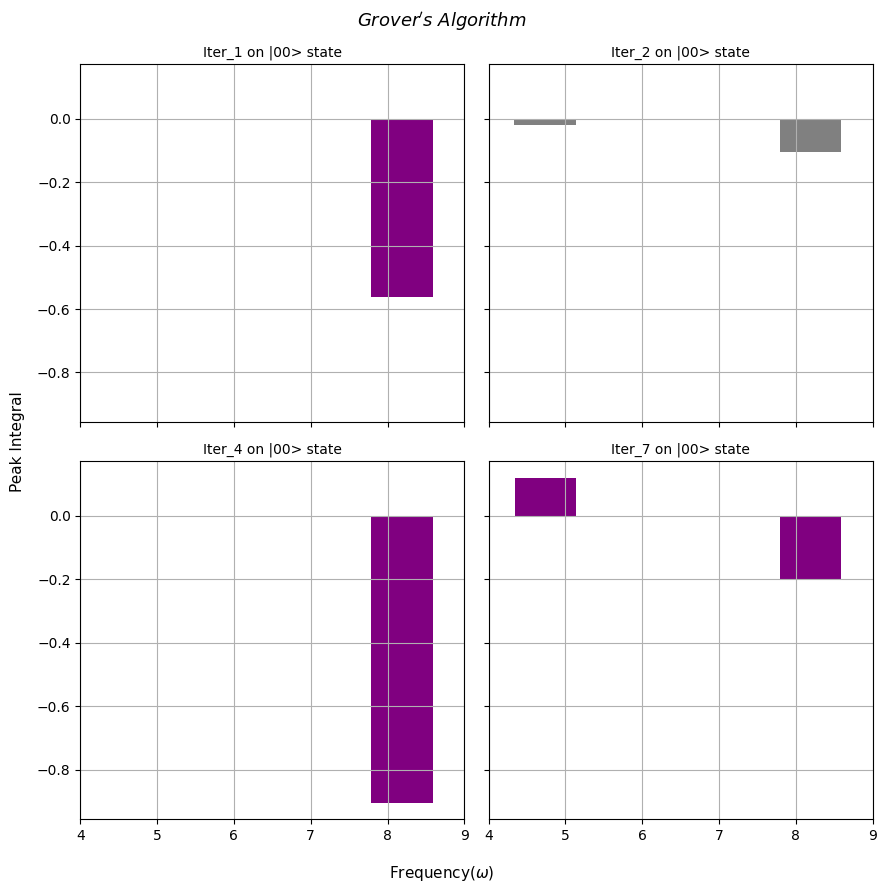

In [12]:
PATH = "/Users/shashank/Documents/NMR/Grover_s/"
states = ['Iter_1', 'Iter_2', 'Iter_4', 'Iter_7']
n_files = len(states)
locs = []
ints = []

for j in range(n_files):
    complete_path = PATH + states[j] + '/'

    fileNames = os.listdir(complete_path)
    fileNames_G = [file for file in fileNames]

    df_G = []
    for i, file in enumerate(fileNames_G):
        df = pd.read_csv(complete_path + file, header=None, usecols=[0, 1])
        df_G.append(df)

    sum_G = 0
    for df in df_G:
        freq_G = df.iloc[:,0]
        sum_G += df.iloc[:,1]


    peak_loc_G, int_G = integrator(np.array(freq_G), np.array(sum_G)/3, 4, 9, 0.6)

    locs.append(peak_loc_G)
    ints.append(int_G)


plt.rcParams['axes.grid'] = True
fig, ax = plt.subplots(2, 2, sharex = 'all', sharey = 'all', figsize = (9,9))
fig.suptitle('Grover$\'$s Algorithm', fontsize=13, style = 'italic') 
fig.supxlabel('Frequency($\omega$)', fontsize = 11)
fig.supylabel('Peak Integral', fontsize = 11)

ax[0,0].set_xlim(4, 9)
ax[0,0].bar(locs[0], ints[0], color = 'purple')
ax[0,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[0,0].set_title(f"{states[0]} on |00> state", size = 10)

ax[0,1].bar(locs[1], ints[1], color = 'gray')
ax[0,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[0,1].set_title(f"{states[1]} on |00> state", size = 10)

ax[1,0].bar(locs[2], ints[2], color = 'purple')
ax[1,0].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[1,0].set_title(f"{states[2]} on |00> state", size = 10)

ax[1,1].bar(locs[3], ints[3], color = 'purple')
ax[1,1].axvline(x = 3.01, linestyle = 'dashed', linewidth = 1, color = 'black')
ax[1,1].set_title(f"{states[3]} on |00> state", size = 10)

fig.tight_layout()
plt.show()